In [1]:
!pip install vaderSentiment

In [0]:
import pandas as pd


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import nltk
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize,sent_tokenize
from gensim import corpora
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt


In [0]:
df_train = pd.read_csv("/content/labeled_data.csv")[["tweet","class"]]
df_train.loc[df_train['class'] == 2, 'class'] = 1
df_train=df_train.sample(frac=1)

In [0]:
X_train = df_train[df_train['class']==0]
X__train = df_train[df_train['class']==1][:len(X_train["class"])]
df_train = X_train.append(X__train)


In [45]:
nltk.download("stopwords")
from nltk.stem.porter import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt","RT"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    
    #Lowercase string
    text_string=text_string.lower()
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    
    #Stem it
    tweet = " ".join(re.split("[^a-zA-Z]*", parsed_text)).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens
  
  
def pos_tag_seq(tokens):
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    return tag_str
  
  

In [0]:
def join_sent(l):
  return " ".join(l)

In [48]:
df_train.head()

,tweet,class,counts,len,word_count,pos,neg,neu
16489,"RT @Mitchellharri: Dont be a faggot, cover you...",0,"(0, 1, 0)",128,24,0.334,0.000,0.666
24091,ion speak on how flaw niggas and thirsty hoes ...,0,"(0, 0, 2)",100,18,0.000,0.091,0.909
15093,RT @EarlyLegend: I don't fuck with these hoes ...,0,"(0, 1, 0)",101,18,0.373,0.000,0.627
21578,The leftist/homosexual war on the #Catholic ch...,0,"(0, 0, 1)",134,20,0.000,0.170,0.830
10083,I bet you think you a no-chill savage huh. Fuc...,0,"(0, 1, 0)",68,12,0.000,0.490,0.510


In [49]:
s_train=df_train['tweet'].apply(preprocess)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [0]:
s_tr=s_train.apply(join_sent)

In [0]:
vectorizer = TfidfVectorizer(
    preprocessor=None,
    lowercase=False,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    stop_words=stopwords,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75)


In [0]:
tfidf_tr = vectorizer.fit_transform(s_tr).toarray()

vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
sentiment_analyzer = VS()


In [0]:
def get_sentiment(text):
  sentiment = sentiment_analyzer.polarity_scores(text)
  return sentiment

#   return sentiment["neg"], sentiment["pos"], sentiment["neu"]

In [0]:
df_train["sent"]=df_train["tweet"].apply(get_sentiment) 

In [0]:
foo_tr = lambda x: pd.Series([x["pos"],x["neg"],x["neu"]])
rev_tr = df_train['sent'].apply(foo_tr)


In [0]:
rev_tr.columns=["pos","neg","neu"]

In [58]:
rev_tr.head()

,pos,neg,neu
16489,0.334,0.000,0.666
24091,0.000,0.091,0.909
15093,0.373,0.000,0.627
21578,0.000,0.170,0.830
10083,0.000,0.490,0.510


In [0]:
def return_cont(parsed_text):
  return(parsed_text.count('urlher'),parsed_text.count('mentionher'),parsed_text.count('hashtagher'))

In [0]:
df_train["counts"]=s_tr.apply(return_cont) 

In [0]:
foo = lambda x: pd.Series([x[0],x[1],x[2]])
mention_counts_tr = df_train['counts'].apply(foo)


In [62]:
!pip install textstat
from textstat.textstat import *

In [0]:
def get_other_features(text):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    words = re.sub(mention_regex, '', parsed_text)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_terms, num_words,
                num_unique_terms]
    return features
    
  

In [0]:
other_feats_tr=df_train["tweet"].apply(get_other_features)

In [0]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars","num_terms", "num_words", "num_unique_words"]

In [0]:
foo = lambda x: pd.Series(elem for elem in x)
of_counts_tr = other_feats_tr.apply(foo)

In [0]:
of_counts_tr.columns=other_features_names

In [68]:
#Removing unnecessary columns
df_train.drop([ "sent","counts"], axis=1)

,tweet,class,len,word_count,pos,neg,neu
16489,"RT @Mitchellharri: Dont be a faggot, cover you...",0,128,24,0.334,0.000,0.666
24091,ion speak on how flaw niggas and thirsty hoes ...,0,100,18,0.000,0.091,0.909
15093,RT @EarlyLegend: I don't fuck with these hoes ...,0,101,18,0.373,0.000,0.627
21578,The leftist/homosexual war on the #Catholic ch...,0,134,20,0.000,0.170,0.830
10083,I bet you think you a no-chill savage huh. Fuc...,0,68,12,0.000,0.490,0.510
3869,@L1LTR4P fucking losers wetbacks #SorryNotSorry,0,47,5,0.000,0.480,0.520
7674,Almost got to see a white boy get beat around ...,0,77,17,0.152,0.242,0.606
3310,@GrizzboAdams @wyattnuckels haha ight nig calm...,0,53,7,0.515,0.000,0.485
8041,"Bitch ass nigga, be hating on black women... U...",0,66,12,0.000,0.643,0.357
7548,Al noooo ...... Too late fuckin faggot ! Lmao,0,45,9,0.267,0.322,0.411


In [0]:
import numpy as np
x_train=np.concatenate([pd.DataFrame(tfidf_tr),rev_tr,mention_counts_tr, of_counts_tr],axis=1 )


In [70]:
x_train[:10]

array([[ 0.,  0.,  0., ..., 24., 24., 23.],
       [ 0.,  0.,  0., ..., 18., 18., 17.],
       [ 0.,  0.,  0., ..., 18., 18., 12.],
       ...,
       [ 0.,  0.,  0., ...,  7.,  5.,  5.],
       [ 0.,  0.,  0., ..., 12., 12., 12.],
       [ 0.,  0.,  0., ...,  9.,  9.,  9.]])

In [0]:
df_train['len'] = df_train['tweet'].astype(str).apply(len)
df_train['word_count'] = df_train['tweet'].apply(lambda x: len(str(x).split()))

In [0]:
df_train["pos"]=rev_tr["pos"]

In [0]:
df_train["neg"]=rev_tr["neg"]
df_train["neu"]=rev_tr["neu"]

In [74]:
df_train.head()

,tweet,class,counts,len,word_count,pos,neg,neu,sent
16489,"RT @Mitchellharri: Dont be a faggot, cover you...",0,"(0, 1, 0)",128,24,0.334,0.000,0.666,"{'neg': 0.0, 'neu': 0.666, 'pos': 0.334, 'comp..."
24091,ion speak on how flaw niggas and thirsty hoes ...,0,"(0, 0, 2)",100,18,0.000,0.091,0.909,"{'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'comp..."
15093,RT @EarlyLegend: I don't fuck with these hoes ...,0,"(0, 1, 0)",101,18,0.373,0.000,0.627,"{'neg': 0.0, 'neu': 0.627, 'pos': 0.373, 'comp..."
21578,The leftist/homosexual war on the #Catholic ch...,0,"(0, 0, 1)",134,20,0.000,0.170,0.830,"{'neg': 0.17, 'neu': 0.83, 'pos': 0.0, 'compou..."
10083,I bet you think you a no-chill savage huh. Fuc...,0,"(0, 1, 0)",68,12,0.000,0.490,0.510,"{'neg': 0.49, 'neu': 0.51, 'pos': 0.0, 'compou..."


In [0]:
df_train=df_train.drop(["sent"], axis=1)

In [76]:
df_train.drop(["counts"], axis=1)
# pd.concat([df_train,pd.DataFrame(x_train)], axis=1)

,tweet,class,len,word_count,pos,neg,neu
16489,"RT @Mitchellharri: Dont be a faggot, cover you...",0,128,24,0.334,0.000,0.666
24091,ion speak on how flaw niggas and thirsty hoes ...,0,100,18,0.000,0.091,0.909
15093,RT @EarlyLegend: I don't fuck with these hoes ...,0,101,18,0.373,0.000,0.627
21578,The leftist/homosexual war on the #Catholic ch...,0,134,20,0.000,0.170,0.830
10083,I bet you think you a no-chill savage huh. Fuc...,0,68,12,0.000,0.490,0.510
3869,@L1LTR4P fucking losers wetbacks #SorryNotSorry,0,47,5,0.000,0.480,0.520
7674,Almost got to see a white boy get beat around ...,0,77,17,0.152,0.242,0.606
3310,@GrizzboAdams @wyattnuckels haha ight nig calm...,0,53,7,0.515,0.000,0.485
8041,"Bitch ass nigga, be hating on black women... U...",0,66,12,0.000,0.643,0.357
7548,Al noooo ...... Too late fuckin faggot ! Lmao,0,45,9,0.267,0.322,0.411


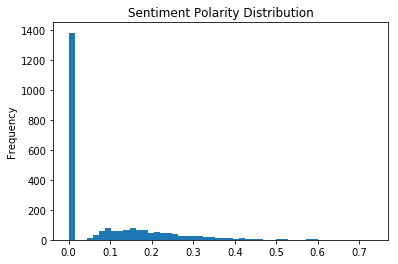

In [77]:
df_train['pos'].plot(
    kind='hist',
    bins=50,
#     xTitle='polarity',
#     linecolor='black',
#     yTitle='count',
    title='Sentiment Polarity Distribution')

(array([1431.,  332.,  306.,  178.,  101.,   44.,   20.,   12.,    4.,
           2.]),
 array([0.    , 0.0733, 0.1466, 0.2199, 0.2932, 0.3665, 0.4398, 0.5131,
        0.5864, 0.6597, 0.733 ]),
 <a list of 10 Patch objects>)

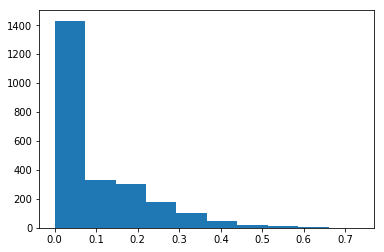

In [78]:
import matplotlib.pyplot as plt 
plt.hist(df_train["pos"]) 
    
  

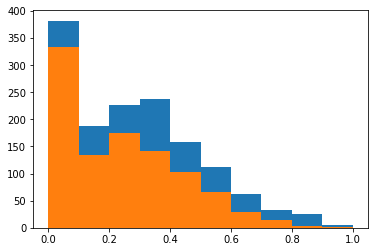

In [79]:
import matplotlib.pyplot as plt 

plt.hist(df_train.loc[df_train['class'] == 0]["neg"]) 
plt.hist(df_train.loc[df_train['class'] == 1]["neg"]) 
plt.show()

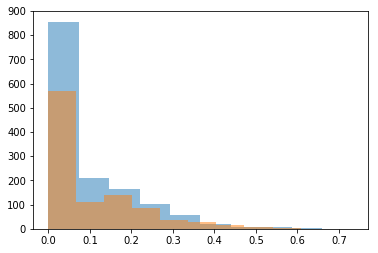

In [80]:
plt.hist(df_train.loc[df_train['class'] == 0]["pos"], alpha=0.5) 
plt.hist(df_train.loc[df_train['class'] == 1]["pos"],alpha=0.5) 
plt.show()

(array([1430.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

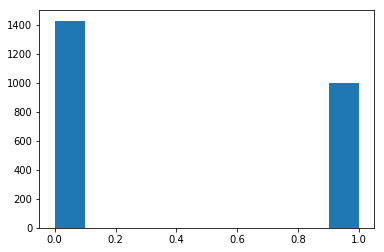

In [81]:
plt.hist(df_train['class']) 

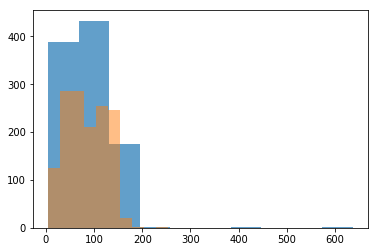

In [83]:
plt.hist(df_train.loc[df_train['class'] == 1]["len"],alpha=0.7) 
plt.hist(df_train.loc[df_train['class'] == 0]["len"],alpha=0.5) 
plt.show()

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



bitch 346
rt 333
the 309
you 260
to 242
and 172
that 159
my 156
bitches 132
in 126
is 122
co 119
http 115
of 113
on 110
it 106
hoes 104
me 103
for 102
128514 101


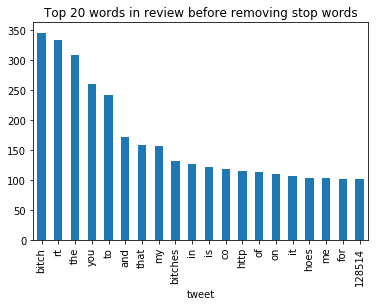

In [85]:
temp_df=df_train.loc[df_train['class'] == 1]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


you 505
the 388
rt 328
to 323
and 234
bitch 209
is 205
that 196
faggot 191
like 169
in 163
of 153
my 145
nigga 140
ass 138
be 131
white 127
me 127
all 126
co 126


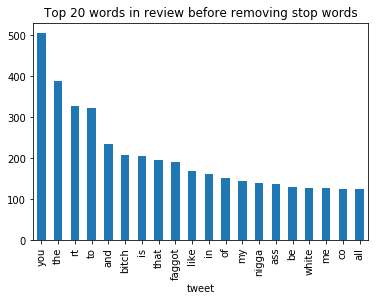

In [86]:
temp_df=df_train.loc[df_train['class'] == 0]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


rt 328
bitch 209
faggot 191
like 169
nigga 140
ass 138
white 127
fuck 121
http 117
trash 113
nigger 112
128514 96
fucking 95
don 77
niggas 76
fag 76
just 75
8221 66
8220 64
faggots 62


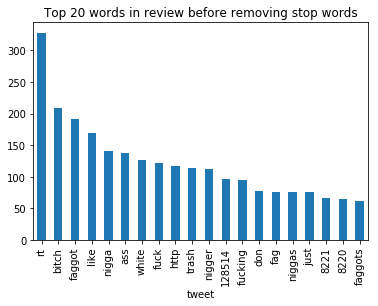

In [88]:
temp_df=df_train.loc[df_train['class'] == 0]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


bitch 346
rt 333
bitches 132
http 115
hoes 104
128514 101
like 98
hoe 84
pussy 79
got 70
8220 66
ass 64
don 64
128175 64
just 62
fuck 62
8221 62
8230 60
shit 55
amp 48


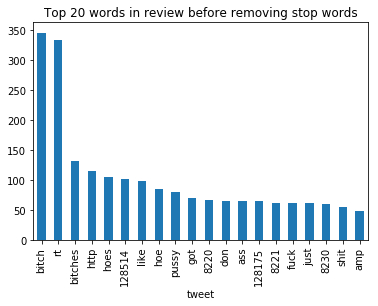

In [89]:
temp_df=df_train.loc[df_train['class'] == 1]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


##Bigrams

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

white trash 62
128514 128514 49
ass nigga 23
look like 17
bitch ass 15
fucking faggot 11
faggot ass 10
bitch nigga 10
looks like 9
white people 8
nigga bitch 8
ass niggas 8
fuck bitch 8
don like 8
happy birthday 8
like bitch 7
128514 128557 7
just like 7
black people 7
http 8230 7


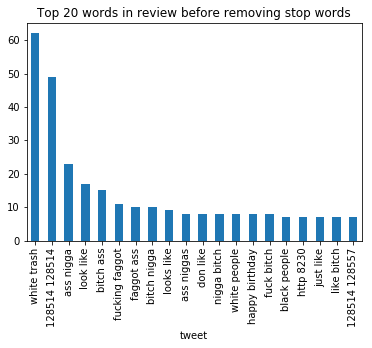

In [91]:
temp_df=df_train.loc[df_train['class'] == 0]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


128175 128175 57
128514 128514 49
12288 12288 35
cunt cunt 14
bitch ass 11
fuck bitch 10
look like 9
ass bitch 8
like bitch 8
bad bitches 8
yo bitch 7
bitch lol 7
eat pussy 7
bad bitch 7
bitch got 7
bitch just 6
hoes ain 6
bitch bitch 6
128514 128557 6
http 8230 6


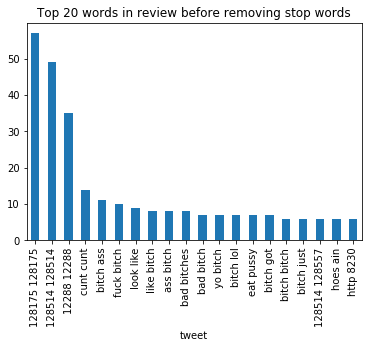

In [92]:
temp_df=df_train.loc[df_train['class'] == 1]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


#Trigrams

In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


  

128514 128514 128514 23
bitch ass nigga 7
nigga nigga nigga 4
got niggas amp 3
uncle tom ass 3
creepy ass cracker 3
pussy ass nigga 3
da colored folk 3
softestmuffin _tee13 torahblaze 3
happy birthday faggot 3
means white trash 3
127850 127850 127850 3
128079 128079 128079 3
128077 128077 128077 3
128557 128557 128557 3
niggas amp got 2
amp got bitches 2
sizzurp__ bootyacid ilikecats74 2
bootyacid ilikecats74 yopapi_chulo 2
128514 128514 bitch 2


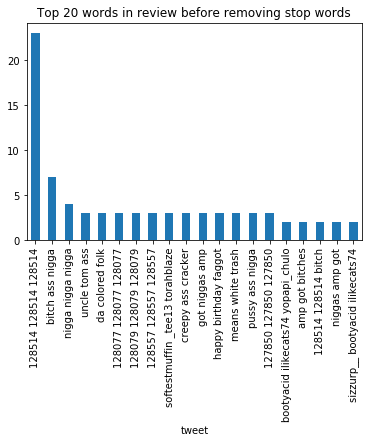

In [94]:
temp_df=df_train.loc[df_train['class'] == 0]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


128175 128175 128175 55
12288 12288 12288 32
128514 128514 128514 26
cunt cunt cunt 13
128525 128525 128525 3
hate ing bus 3
128543 128543 128543 3
bitch bitch bitch 3
got hoes got 3
hoes got hoes 3
hoe 128514 128514 3
bitches love beyonce 2
don trust hoes 2
hoes ain loyal 2
128056 9749 65039 2
hurts like bitch 2
big booty bitches 2
use word cunt 2
love bad bitches 2
playing flappy bird 2


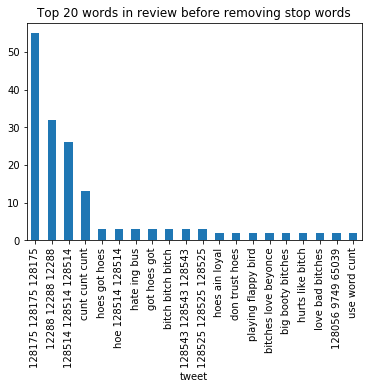

In [95]:
temp_df=df_train.loc[df_train['class'] == 1]["tweet"]
common_words = get_top_n_words(temp_df, 20)
for word, freq in common_words:
    print(word, freq)  
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
df1.groupby('tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review before removing stop words')


#POS tags

In [96]:
!pip install TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
import textblob
from textblob import TextBlob

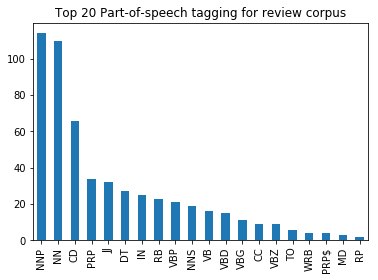

In [98]:
blob = TextBlob(str(df_train['tweet']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(
    kind='bar',
    title='Top 20 Part-of-speech tagging for review corpus')


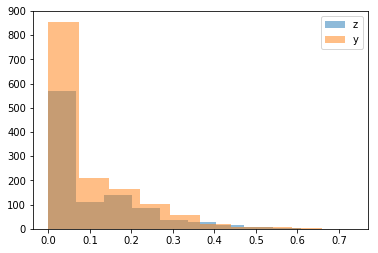

In [100]:
from matplotlib import pyplot

y = df_train.loc[df_train['class'] == 0, 'pos']
z = df_train.loc[df_train['class'] == 1, 'pos']

pyplot.hist(z,  label='z', alpha=0.5)
pyplot.hist(y,  label='y', alpha=0.5)
pyplot.legend(loc='upper right')
pyplot.show()

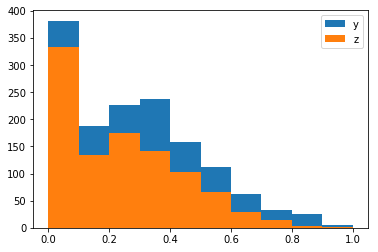

In [102]:
from matplotlib import pyplot

y = df_train.loc[df_train['class'] == 0, 'neg']
z = df_train.loc[df_train['class'] == 1, 'neg']


pyplot.hist(y,  label='y')
pyplot.hist(z,  label='z')
pyplot.legend(loc='upper right')
pyplot.show()

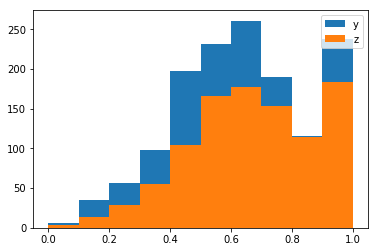

In [103]:
from matplotlib import pyplot

y = df_train.loc[df_train['class'] == 0, 'neu']
z = df_train.loc[df_train['class'] == 1, 'neu']


pyplot.hist(y,  label='y')
pyplot.hist(z,  label='z')
pyplot.legend(loc='upper right')
pyplot.show()

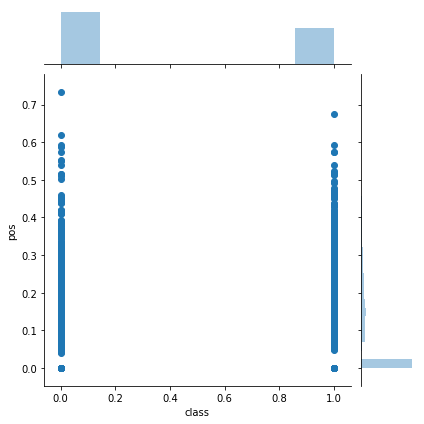

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df=df_train[["class","pos"]]
sns.jointplot(x="class", y="pos", data=df)

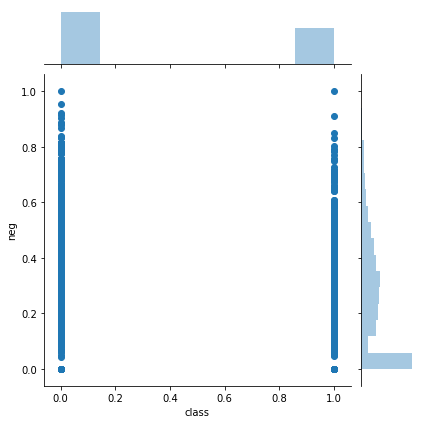

In [105]:
df=df_train[["class","neg"]]
sns.jointplot(x="class", y="neg", data=df)

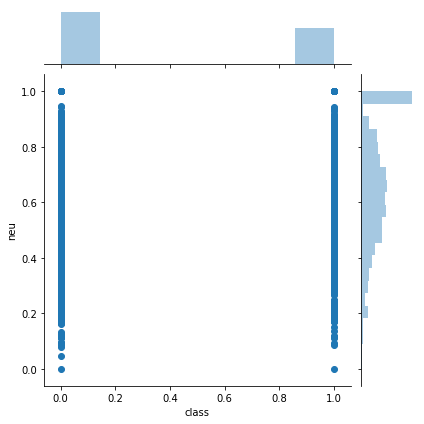

In [106]:
df=df_train[["class","neu"]]
sns.jointplot(x="class", y="neu", data=df)